## Set up drive path

In [0]:
# !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
# !add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
# !apt-get update -qq 2>&1 > /dev/null
# !apt-get -y install -qq google-drive-ocamlfuse fuse
# from google.colab import auth
# auth.authenticate_user()
# from oauth2client.client import GoogleCredentials
# creds = GoogleCredentials.get_application_default()
# import getpass
# !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
# vcode = getpass.getpass()
# !echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
# !mkdir -p drive
# !google-drive-ocamlfuse drive

In [1]:
ls

datalab@  sample_data/


In [5]:
cd drive/VAE

/content/drive/VAE


## Import library  and define functions

In [0]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import os
import matplotlib.pyplot as plt

# Import dataset with one-hot encoding of the class labels.
def get_data():
    return input_data.read_data_sets("MNIST_data/", one_hot=True)

# Placeholders to feed train and test data into the graph.
# Since batch dimension is 'None', we can reuse them both for train and eval.
def get_placeholders():
    x = tf.placeholder(tf.float32, [None, 784])
    return x
  
def binarize(images, threshold=0.1):
  return (threshold < images).astype('float32')

def text_save(content,filename,mode='a'):
    # Try to save a list variable in txt file.
    file = open(filename,mode)
    for i in range(len(content)):
        file.write(str(content[i])+'\n')
    file.close()
    
def text_read(filename):
    # Try to read a txt file and return a list.Return [] if there was a mistake.
    try:
        file = open(filename,'r')
    except IOError:
        error = []
        return error
    content = file.readlines()
 
    for i in range(len(content)):
        content[i] = content[i][:len(content[i])-1]
 
    file.close()
    return content

## MNIST Dataset

In [14]:
show_mnist = get_data()        # use for training.

x_sample = show_mnist.test.images[:100]
binary_x_sample = binarize(x_sample)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


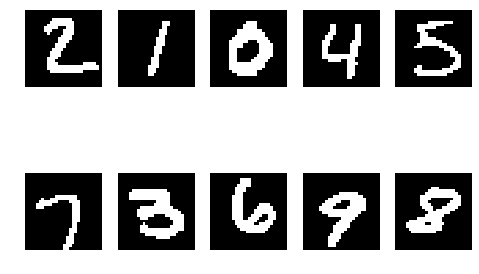

In [91]:
ddi = 0
idlist = [1,2,3,4,15,26,51,88,9,61]
fig = plt.figure()

for j in range(2): 
  for i in range(5):
    ddi = ddi+1
    plt.subplot(2,5,ddi)   
    plt.imshow(np.reshape(binary_x_sample[idlist[ddi-1]], (28,28)),cmap="gray")
    plt.axis('off')
    
fig.savefig('mnist_samples.png', dpi=fig.dpi)

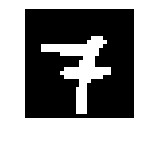

In [123]:
fig = plt.figure(figsize=(2,2))
plt.imshow(np.reshape(binary_x_sample[75], (28,28)),cmap="gray")
plt.axis('off')
fig.savefig('one_7_sample.png', dpi=fig.dpi)

## Models

### Latent dimension = 5

In [0]:
#####################################################
# Define model, loss, update and evaluation metric. #
#####################################################

# Global variables.
batch_size = 100
learning_rate = 0.01
image_dim = 784
hidden_dim = 500

latent_dim = 5


# Reset graph, recreate placeholders and dataset.
tf.reset_default_graph()  # reset the tensorflow graph
x = get_placeholders()

def vari_init(shape):
    return tf.random_normal(shape=shape, stddev=0.01, mean=0.0)
  
# intialize encoder parameters
w_1_en = tf.Variable(vari_init([image_dim, hidden_dim]))
b_1_en = tf.Variable(vari_init([hidden_dim,]))

w_2_en = tf.Variable(vari_init([hidden_dim, latent_dim]))
b_2_en = tf.Variable(vari_init([latent_dim,]))

w_3_en = tf.Variable(vari_init([hidden_dim, latent_dim]))
b_3_en = tf.Variable(vari_init([latent_dim,]))

w_1_de = tf.Variable(vari_init([latent_dim, hidden_dim]))
b_1_de = tf.Variable(vari_init([hidden_dim,]))

w_2_de = tf.Variable(vari_init([hidden_dim, image_dim]))
b_2_de = tf.Variable(vari_init([image_dim,]))

encoder = tf.nn.tanh(tf.matmul(x,w_1_en) + b_1_en)

z_mean = tf.matmul(encoder,w_2_en) + b_2_en

z_log_var = tf.matmul(encoder,w_3_en) + b_3_en
z_var = tf.exp(z_log_var)
z_std = tf.sqrt(z_var)

eposida = tf.random_normal(tf.shape(z_std), mean=0.0,stddev=1)
z = z_mean + z_std*eposida

inter_1 = tf.nn.tanh(tf.matmul(z,w_1_de) + b_1_de)
decoder = tf.nn.sigmoid(tf.matmul(inter_1,w_2_de)+b_2_de)


# Define VAE Loss

def vae_loss(x_reconstructed, x_true):
  
    # Reconstruction loss   
    encode_decode_loss = x_true * tf.log(1e-10 + x_reconstructed) \
                         + (1 - x_true) * tf.log(1e-10 + 1 - x_reconstructed)
    encode_decode_loss = -tf.reduce_sum(encode_decode_loss, 1)
    
    # KL Divergence loss
    kl_div_loss = 1 + z_log_var - tf.square(z_mean) - z_var
    kl_div_loss = -0.5 * tf.reduce_sum(kl_div_loss, 1)
    
    return tf.reduce_mean(encode_decode_loss + kl_div_loss)


loss_op = vae_loss(decoder, x)
update = tf.train.AdagradOptimizer(learning_rate=learning_rate).minimize(loss_op)

def save_model(session, path):
    if not os.path.exists('./result_5/'):
        os.mkdir('./result_5/')
    saver = tf.train.Saver()
    saver.save(session, path)

path1 = './result_5/model_epch5.ckpt'

In [0]:
def save_model(session, path):
    if not os.path.exists('./result_5/'):
        os.mkdir('./result_5/')
    saver = tf.train.Saver()
    saver.save(session, path)

path1 = './result_5/model_epch5.ckpt'

In [5]:
#####################################################
###################### Training #####################
#####################################################

mnist = get_data()        # use for training.
eva_mnist = get_data()    # use for testing.

num_epochs = 100
i, train_elbo, test_elbo = 0, [], []

init = tf.global_variables_initializer()

with tf.Session() as sess:
  
    sess.run(init)    
    
    while mnist.train.epochs_completed < num_epochs:
   
        i += 1    
        batch_xs, _ = mnist.train.next_batch(batch_size)
        batch_xs_bi = binarize(batch_xs)
        feed_dict = {x: batch_xs_bi,}
        
        _ = sess.run(update, feed_dict=feed_dict)
        
        if i % 1000 == 0 or i == 1:
            
            
            test = binarize(eva_mnist.test.images)
            train = binarize(eva_mnist.train.images[:10000])

            test_feed_dict = {x: test,}
            train_feed_dict = {x: train,}
            
            testElbo = sess.run(loss_op, feed_dict=test_feed_dict)
            trainElbo = sess.run(loss_op, feed_dict=train_feed_dict)
            
            test_elbo.append(-testElbo)
            train_elbo.append(-trainElbo)
            
            print('Step %i, Train Lower likelihood: %f' % (i, -trainElbo))
            print('Step %i, Test Lower likelihood: %f' % (i, -testElbo))
    
    
    save_model(sess, path1)
    
text_save(train_elbo, 'train_elbo_la_5.txt')
text_save(test_elbo, 'test_elbo_la_5.txt')

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Step 1, Train Lower likelihood: -541.041748
Step 1, Test Lower likelihood: -541.027527
Step 1000, Train Low

In [21]:
with tf.Session() as sess:
  
    # LOAD THE MODEL
    saver = tf.train.Saver()  
    saver.restore(sess, path1)
    
    x_sample = binarize(eva_mnist.test.images[:100])
    
    feed_dict = {x: x_sample,}
    
    reconstruct_mean_la_5 = sess.run(decoder, feed_dict=feed_dict)

INFO:tensorflow:Restoring parameters from ./result_5/model_epch5.ckpt


### Latent dimension = 10

In [0]:
#####################################################
# Define model, loss, update and evaluation metric. #
#####################################################

# Global variables.
batch_size = 100
learning_rate = 0.01
image_dim = 784
hidden_dim = 500

latent_dim = 10


# Reset graph, recreate placeholders and dataset.
tf.reset_default_graph()  # reset the tensorflow graph
x = get_placeholders()

def vari_init(shape):
    return tf.random_normal(shape=shape, stddev=0.01, mean=0.0)
  
# intialize encoder parameters
w_1_en = tf.Variable(vari_init([image_dim, hidden_dim]))
b_1_en = tf.Variable(vari_init([hidden_dim,]))

w_2_en = tf.Variable(vari_init([hidden_dim, latent_dim]))
b_2_en = tf.Variable(vari_init([latent_dim,]))

w_3_en = tf.Variable(vari_init([hidden_dim, latent_dim]))
b_3_en = tf.Variable(vari_init([latent_dim,]))

w_1_de = tf.Variable(vari_init([latent_dim, hidden_dim]))
b_1_de = tf.Variable(vari_init([hidden_dim,]))

w_2_de = tf.Variable(vari_init([hidden_dim, image_dim]))
b_2_de = tf.Variable(vari_init([image_dim,]))

encoder = tf.nn.tanh(tf.matmul(x,w_1_en) + b_1_en)

z_mean = tf.matmul(encoder,w_2_en) + b_2_en

z_log_var = tf.matmul(encoder,w_3_en) + b_3_en
z_var = tf.exp(z_log_var)
z_std = tf.sqrt(z_var)

eposida = tf.random_normal(tf.shape(z_std), mean=0.0,stddev=1)
z = z_mean + z_std*eposida

inter_1 = tf.nn.tanh(tf.matmul(z,w_1_de) + b_1_de)
decoder = tf.nn.sigmoid(tf.matmul(inter_1,w_2_de)+b_2_de)


# Define VAE Loss

def vae_loss(x_reconstructed, x_true):
  
    # Reconstruction loss   
    encode_decode_loss = x_true * tf.log(1e-10 + x_reconstructed) \
                         + (1 - x_true) * tf.log(1e-10 + 1 - x_reconstructed)
    encode_decode_loss = -tf.reduce_sum(encode_decode_loss, 1)
    
    # KL Divergence loss
    kl_div_loss = 1 + z_log_var - tf.square(z_mean) - z_var
    kl_div_loss = -0.5 * tf.reduce_sum(kl_div_loss, 1)
    
    return tf.reduce_mean(encode_decode_loss + kl_div_loss)


loss_op = vae_loss(decoder, x)
update = tf.train.AdagradOptimizer(learning_rate=learning_rate).minimize(loss_op)

def save_model(session, path):
    if not os.path.exists('./result_10/'):
        os.mkdir('./result_10/')
    saver = tf.train.Saver()
    saver.save(session, path)

path2 = './result_10/model_epch10.ckpt'

In [8]:
#####################################################
###################### Training #####################
#####################################################

mnist = get_data()        # use for training.
eva_mnist = get_data()    # use for testing.

num_epochs = 100
i, train_elbo, test_elbo = 0, [], []

init = tf.global_variables_initializer()

with tf.Session() as sess:
  
    sess.run(init)    
    
    while mnist.train.epochs_completed < num_epochs:
   
        i += 1    
        batch_xs, _ = mnist.train.next_batch(batch_size)
        batch_xs_bi = binarize(batch_xs)
        feed_dict = {x: batch_xs_bi,}
        
        _, trainElbo = sess.run([update, loss_op], feed_dict=feed_dict)
        
        if i % 1000 == 0 or i == 1:
            
            test = binarize(eva_mnist.test.images)
            train = binarize(eva_mnist.train.images[:10000])

            test_feed_dict = {x: test,}
            train_feed_dict = {x: train,}
            
            testElbo = sess.run(loss_op, feed_dict=test_feed_dict)
            trainElbo = sess.run(loss_op, feed_dict=train_feed_dict)
            
            test_elbo.append(-testElbo)
            train_elbo.append(-trainElbo)
            
            print('Step %i, Train Lower likelihood: %f' % (i, -trainElbo))
            print('Step %i, Test Lower likelihood: %f' % (i, -testElbo))
    
    
    save_model(sess, path2)
    
text_save(train_elbo, 'train_elbo_la_10.txt')
text_save(test_elbo, 'test_elbo_la_10.txt')

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Step 1, Train Lower likelihood: -541.067505
Step 1, Test Lower likelihood: -541.065491
Step 1000, Train Lower likelihood: -189.246933
Step 1000, Test Lower likelihood: -188.103195
Step 2000, Train Lower likelihood: -155.247681
Step 2000, Test Lower likelihood: -154.216202
Step 3000, Train Lower likelihood: -143.061264
Step 3000, Test Lower likelihood: -142.533127
Step 4000, Train Lower likelihood: -131.386551
Step 4000, Test Lower likelihood: -130.982468
Step 5000, Train Lower likelihood: -127.029778
Step 5000, Test Lower likelihood: -126.741302
Step 6000, Train Lower likelihood: -124.246613
Step 6000, Te

In [23]:
with tf.Session() as sess:
  
    # LOAD THE MODEL
    saver = tf.train.Saver()  
    saver.restore(sess, path2)
    
    x_sample = binarize(eva_mnist.test.images[:100])
    
    feed_dict = {x: x_sample,}
    
    reconstruct_mean_la_10 = sess.run(decoder, feed_dict=feed_dict)

INFO:tensorflow:Restoring parameters from ./result_10/model_epch10.ckpt


### Latent dimension = 50

In [0]:
#####################################################
# Define model, loss, update and evaluation metric. #
#####################################################

# Global variables.
batch_size = 100
learning_rate = 0.01
image_dim = 784
hidden_dim = 500

latent_dim = 50


# Reset graph, recreate placeholders and dataset.
tf.reset_default_graph()  # reset the tensorflow graph
x = get_placeholders()

def vari_init(shape):
    return tf.random_normal(shape=shape, stddev=0.01, mean=0.0)
  
# intialize encoder parameters
w_1_en = tf.Variable(vari_init([image_dim, hidden_dim]))
b_1_en = tf.Variable(vari_init([hidden_dim,]))

w_2_en = tf.Variable(vari_init([hidden_dim, latent_dim]))
b_2_en = tf.Variable(vari_init([latent_dim,]))

w_3_en = tf.Variable(vari_init([hidden_dim, latent_dim]))
b_3_en = tf.Variable(vari_init([latent_dim,]))

w_1_de = tf.Variable(vari_init([latent_dim, hidden_dim]))
b_1_de = tf.Variable(vari_init([hidden_dim,]))

w_2_de = tf.Variable(vari_init([hidden_dim, image_dim]))
b_2_de = tf.Variable(vari_init([image_dim,]))

encoder = tf.nn.tanh(tf.matmul(x,w_1_en) + b_1_en)

z_mean = tf.matmul(encoder,w_2_en) + b_2_en

z_log_var = tf.matmul(encoder,w_3_en) + b_3_en
z_var = tf.exp(z_log_var)
z_std = tf.sqrt(z_var)

eposida = tf.random_normal(tf.shape(z_std), mean=0.0,stddev=1)
z = z_mean + z_std*eposida

inter_1 = tf.nn.tanh(tf.matmul(z,w_1_de) + b_1_de)
decoder = tf.nn.sigmoid(tf.matmul(inter_1,w_2_de)+b_2_de)


# Define VAE Loss

def vae_loss(x_reconstructed, x_true):
  
    # Reconstruction loss   
    encode_decode_loss = x_true * tf.log(1e-10 + x_reconstructed) \
                         + (1 - x_true) * tf.log(1e-10 + 1 - x_reconstructed)
    encode_decode_loss = -tf.reduce_sum(encode_decode_loss, 1)
    
    # KL Divergence loss
    kl_div_loss = 1 + z_log_var - tf.square(z_mean) - z_var
    kl_div_loss = -0.5 * tf.reduce_sum(kl_div_loss, 1)
    
    return tf.reduce_mean(encode_decode_loss + kl_div_loss)


loss_op = vae_loss(decoder, x)
update = tf.train.AdagradOptimizer(learning_rate=learning_rate).minimize(loss_op)

def save_model(session, path):
    if not os.path.exists('./result_50/'):
        os.mkdir('./result_50/')
    saver = tf.train.Saver()
    saver.save(session, path)

path3 = './result_50/model_epch50.ckpt'

In [11]:
#####################################################
###################### Training #####################
#####################################################

mnist = get_data()        # use for training.
eva_mnist = get_data()    # use for testing.

num_epochs = 100
i, train_elbo, test_elbo = 0, [], []

init = tf.global_variables_initializer()

with tf.Session() as sess:
  
    sess.run(init)    
    
    while mnist.train.epochs_completed < num_epochs:
   
        i += 1    
        batch_xs, _ = mnist.train.next_batch(batch_size)
        batch_xs_bi = binarize(batch_xs)
        feed_dict = {x: batch_xs_bi,}
        
        _, trainElbo = sess.run([update, loss_op], feed_dict=feed_dict)
        
        if i % 1000 == 0 or i == 1:
            
            test = binarize(eva_mnist.test.images)
            train = binarize(eva_mnist.train.images[:10000])

            test_feed_dict = {x: test,}
            train_feed_dict = {x: train,}
            
            testElbo = sess.run(loss_op, feed_dict=test_feed_dict)
            trainElbo = sess.run(loss_op, feed_dict=train_feed_dict)
            
            test_elbo.append(-testElbo)
            train_elbo.append(-trainElbo)

            print('Step %i, Train Lower likelihood: %f' % (i, -trainElbo))
            print('Step %i, Test Lower likelihood: %f' % (i, -testElbo))
    
    
    save_model(sess, path3)
    
text_save(train_elbo, 'train_elbo_la_50.txt')
text_save(test_elbo, 'test_elbo_la_50.txt')

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Step 1, Train Lower likelihood: -540.933044
Step 1, Test Lower likelihood: -540.922729
Step 1000, Train Lower likelihood: -200.512207
Step 1000, Test Lower likelihood: -198.504776
Step 2000, Train Lower likelihood: -168.444244
Step 2000, Test Lower likelihood: -167.806412
Step 3000, Train Lower likelihood: -152.847412
Step 3000, Test Lower likelihood: -151.900208
Step 4000, Train Lower likelihood: -140.199554
Step 4000, Test Lower likelihood: -139.662231
Step 5000, Train Lower likelihood: -134.272125
Step 5000, Test Lower likelihood: -133.566895
Step 6000, Train Lower likelihood: -129.604385
Step 6000, Te

In [25]:
with tf.Session() as sess:
  
    # LOAD THE MODEL
    saver = tf.train.Saver()  
    saver.restore(sess, path3)
    
    x_sample = binarize(eva_mnist.test.images[:100])
    
    feed_dict = {x: x_sample,}
    
    reconstruct_mean_la_50 = sess.run(decoder, feed_dict=feed_dict)

INFO:tensorflow:Restoring parameters from ./result_50/model_epch50.ckpt


### Latent dimension = 200

In [0]:
#####################################################
# Define model, loss, update and evaluation metric. #
#####################################################

# Global variables.
batch_size = 100
learning_rate = 0.01
image_dim = 784
hidden_dim = 500

latent_dim = 200


# Reset graph, recreate placeholders and dataset.
tf.reset_default_graph()  # reset the tensorflow graph
x = get_placeholders()

def vari_init(shape):
    return tf.random_normal(shape=shape, stddev=0.01, mean=0.0)
  
# intialize encoder parameters
w_1_en = tf.Variable(vari_init([image_dim, hidden_dim]))
b_1_en = tf.Variable(vari_init([hidden_dim,]))

w_2_en = tf.Variable(vari_init([hidden_dim, latent_dim]))
b_2_en = tf.Variable(vari_init([latent_dim,]))

w_3_en = tf.Variable(vari_init([hidden_dim, latent_dim]))
b_3_en = tf.Variable(vari_init([latent_dim,]))

w_1_de = tf.Variable(vari_init([latent_dim, hidden_dim]))
b_1_de = tf.Variable(vari_init([hidden_dim,]))

w_2_de = tf.Variable(vari_init([hidden_dim, image_dim]))
b_2_de = tf.Variable(vari_init([image_dim,]))

encoder = tf.nn.tanh(tf.matmul(x,w_1_en) + b_1_en)

z_mean = tf.matmul(encoder,w_2_en) + b_2_en

z_log_var = tf.matmul(encoder,w_3_en) + b_3_en
z_var = tf.exp(z_log_var)
z_std = tf.sqrt(z_var)

eposida = tf.random_normal(tf.shape(z_std), mean=0.0,stddev=1)
z = z_mean + z_std*eposida

inter_1 = tf.nn.tanh(tf.matmul(z,w_1_de) + b_1_de)
decoder = tf.nn.sigmoid(tf.matmul(inter_1,w_2_de)+b_2_de)


# Define VAE Loss

def vae_loss(x_reconstructed, x_true):
  
    # Reconstruction loss   
    encode_decode_loss = x_true * tf.log(1e-10 + x_reconstructed) \
                         + (1 - x_true) * tf.log(1e-10 + 1 - x_reconstructed)
    encode_decode_loss = -tf.reduce_sum(encode_decode_loss, 1)
    
    # KL Divergence loss
    kl_div_loss = 1 + z_log_var - tf.square(z_mean) - z_var
    kl_div_loss = -0.5 * tf.reduce_sum(kl_div_loss, 1)
    
    return tf.reduce_mean(encode_decode_loss + kl_div_loss)


loss_op = vae_loss(decoder, x)
update = tf.train.AdagradOptimizer(learning_rate=learning_rate).minimize(loss_op)

def save_model(session, path):
    if not os.path.exists('./result_200/'):
        os.mkdir('./result_200/')
    saver = tf.train.Saver()
    saver.save(session, path)

path4 = './result_200/model_epch200.ckpt'

In [14]:
#####################################################
###################### Training #####################
#####################################################

mnist = get_data()        # use for training.
eva_mnist = get_data()    # use for testing.

num_epochs = 100

i, train_elbo, test_elbo = 0, [], []

init = tf.global_variables_initializer()

with tf.Session() as sess:
  
    sess.run(init)    
    
    while mnist.train.epochs_completed < num_epochs:
   
        i += 1    
        batch_xs, _ = mnist.train.next_batch(batch_size)
        batch_xs_bi = binarize(batch_xs)
        feed_dict = {x: batch_xs_bi,}
        
        _, trainElbo = sess.run([update, loss_op], feed_dict=feed_dict)
        
        if i % 1000 == 0 or i == 1:
            
            test = binarize(eva_mnist.test.images)
            train = binarize(eva_mnist.train.images[:10000])

            test_feed_dict = {x: test,}
            train_feed_dict = {x: train,}
            
            testElbo = sess.run(loss_op, feed_dict=test_feed_dict)
            trainElbo = sess.run(loss_op, feed_dict=train_feed_dict)
            
            test_elbo.append(-testElbo)
            train_elbo.append(-trainElbo)
            
            print('Step %i, Train Lower likelihood: %f' % (i, -trainElbo))
            print('Step %i, Test Lower likelihood: %f' % (i, -testElbo))
    
    
    save_model(sess, path4)
    
text_save(train_elbo, './train_elbo_la_200.txt')
text_save(test_elbo, './test_elbo_la_200.txt')

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Step 1, Train Lower likelihood: -541.041626
Step 1, Test Lower likelihood: -541.027222
Step 1000, Train Lower likelihood: -182.318619
Step 1000, Test Lower likelihood: -181.425430
Step 2000, Train Lower likelihood: -155.423569
Step 2000, Test Lower likelihood: -154.751633
Step 3000, Train Lower likelihood: -140.648407
Step 3000, Test Lower likelihood: -140.219406
Step 4000, Train Lower likelihood: -131.661957
Step 4000, Test Lower likelihood: -131.173981
Step 5000, Train Lower likelihood: -124.499153
Step 5000, Test Lower likelihood: -124.065903
Step 6000, Train Lower likelihood: -121.694176
Step 6000, Te

In [32]:
with tf.Session() as sess:
  
    # LOAD THE MODEL
    saver = tf.train.Saver()  
    saver.restore(sess, path4)
    
    x_sample = binarize(eva_mnist.test.images[:100])
    
    feed_dict = {x: x_sample,}
    
    reconstruct_mean_la_100 = sess.run(decoder, feed_dict=feed_dict)

INFO:tensorflow:Restoring parameters from ./result_200/model_epch200.ckpt


## Results

In [0]:
update_step = []
for i in range(55000):
  if i % 1000 == 0 or i == 1:
    update_step.append(i)

In [0]:
train_elbo_la_200 = text_read('./numerical_result/train_elbo_la_200.txt')
test_elbo_la_200 = text_read('./numerical_result/test_elbo_la_200.txt')
train_elbo_la_200 = [float(elbo) for elbo in train_elbo_la_200]
test_elbo_la_200 = [float(elbo) for elbo in test_elbo_la_200]

train_elbo_la_50 = text_read('./numerical_result/train_elbo_la_50.txt')
test_elbo_la_50 = text_read('./numerical_result/test_elbo_la_50.txt')
train_elbo_la_50 = [float(elbo) for elbo in train_elbo_la_50]
test_elbo_la_50 = [float(elbo) for elbo in test_elbo_la_50]

train_elbo_la_10 = text_read('./numerical_result/train_elbo_la_10.txt')
test_elbo_la_10 = text_read('./numerical_result/test_elbo_la_10.txt')
train_elbo_la_10 = [float(elbo) for elbo in train_elbo_la_10]
test_elbo_la_10 = [float(elbo) for elbo in test_elbo_la_10]

train_elbo_la_5 = text_read('./numerical_result/train_elbo_la_5.txt')
test_elbo_la_5 = text_read('./numerical_result/test_elbo_la_5.txt')
train_elbo_la_5 = [float(elbo) for elbo in train_elbo_la_5]
test_elbo_la_5 = [float(elbo) for elbo in test_elbo_la_5]

Text(0.5,1,u'A simple plot')

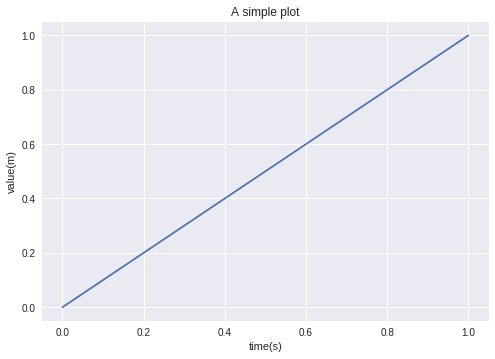

In [6]:
import numpy as np
import matplotlib.pyplot as plt
 
x=[0,1]
y=[0,1]
 
plt.figure()
plt.plot(x,y)
plt.xlabel("time(s)")
plt.ylabel("value(m)")
plt.title("A simple plot")


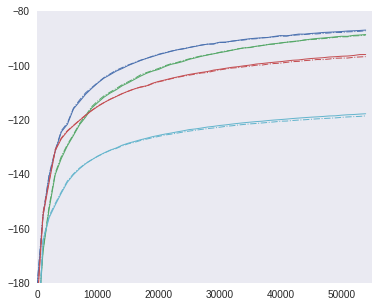

In [29]:
plt.figure(figsize=(6,5))

plt.rcParams['axes.edgecolor'] = 'red'

plt.plot(update_step,train_elbo_la_200, '-', color='C0', linewidth=1.0, label="Train-200")
plt.plot(update_step,test_elbo_la_200, '-.',color='C0', linewidth=1.0, label="Test-200")

plt.plot(update_step,train_elbo_la_50, '-', color='C1', linewidth=1.0, label="Train-50")
plt.plot(update_step,test_elbo_la_50, '-.', color='C1', linewidth=1.0, label="Test-50")

plt.plot(update_step,train_elbo_la_10, '-', color='C8', linewidth=1.0, label="Train-10")
plt.plot(update_step,test_elbo_la_10, '-.', color='C8', linewidth=1.0, label="Test-10")

plt.plot(update_step,train_elbo_la_5, '-', color='C5', linewidth=1.0, label="Train-5")
plt.plot(update_step,test_elbo_la_5, '-.', color='C5', linewidth=1.0, label="Test-5")

plt.ylim((-180, -80))
plt.xlim((0, 55000))

# ax = plt.gca()
# ax.spines['bottom'].set_color('black')
# ax.spines['top'].set_color('black')
# ax.spines['right'].set_color('black')
# ax.spines['left'].set_color('black')


# ax.xaxis.set_ticks_position('bottom')
# ax.yaxis.set_ticks_position('left')

# ax.spines['bottom'].set_position(('data', -180))
# ax.spines['left'].set_position(('data', 0))

#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=1)

#plt.legend(['Train-200', 'Test-200', 'Train-50', 'Test-50', 'Train-10', 'Test-10', 'Train-5', 'Test-5'], fontsize=10, frameon=True) 

plt.grid(False)

plt.show()

(-0.5, 27.5, 27.5, -0.5)

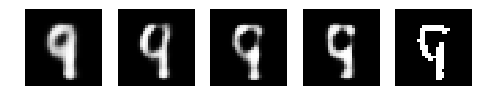

In [38]:
i = 62

plt.subplot(1,5,1)   
im_recon = np.reshape(reconstruct_mean_la_5[i], (28,28))
plt.imshow(im_recon,cmap="gray")
plt.grid(False)
plt.axis('off')

plt.subplot(1,5,2)   
im_recon = np.reshape(reconstruct_mean_la_10[i], (28,28))
plt.imshow(im_recon,cmap="gray")
plt.grid(False)
plt.axis('off')

plt.subplot(1,5,3)   
im_recon = np.reshape(reconstruct_mean_la_50[i], (28,28))
plt.imshow(im_recon,cmap="gray")
plt.grid(False)
plt.axis('off')

plt.subplot(1,5,4)   
im_recon = np.reshape(reconstruct_mean_la_100[i], (28,28))
plt.imshow(im_recon,cmap="gray")
plt.grid(False)
plt.axis('off')

plt.subplot(1,5,5)  
im_recon = np.reshape(binarize(x_sample[i]), (28,28))
plt.imshow(im_recon, cmap="gray")
plt.grid(False)
plt.axis('off')

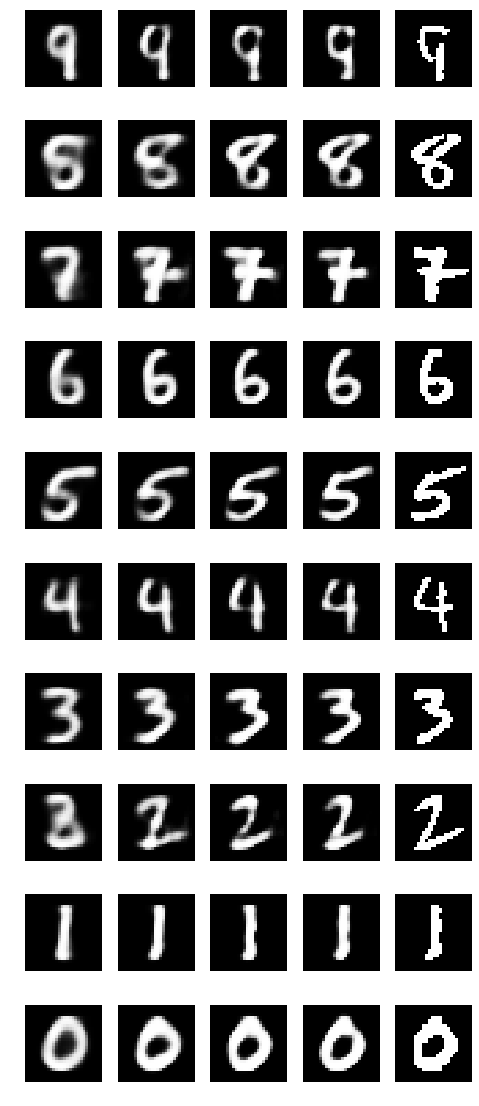

In [34]:
idlist = [62, 84, 97, 21, 52, 24, 30, 38, 14, 3]
model_num = 5
sample_num = 10

i = 0

fig = plt.figure(figsize=(8,20))          # 创建一个figure对象，底下的一切显示均在此figure上完成

for idd in idlist:

  plt.subplot(sample_num,model_num,1+i)   
  im_recon = np.reshape(reconstruct_mean_la_5[idd], (28,28))
  plt.imshow(im_recon,cmap="gray")
  plt.grid(False)
  plt.axis('off')

  plt.subplot(sample_num,model_num,2+i)   
  im_recon = np.reshape(reconstruct_mean_la_10[idd], (28,28))
  plt.imshow(im_recon,cmap="gray")
  plt.grid(False)
  plt.axis('off')


  plt.subplot(sample_num,model_num,3+i)   
  im_recon = np.reshape(reconstruct_mean_la_50[idd], (28,28))
  plt.imshow(im_recon,cmap="gray")
  plt.grid(False)
  plt.axis('off')
  
  plt.subplot(sample_num,model_num,4+i)   
  im_recon = np.reshape(reconstruct_mean_la_100[idd], (28,28))
  plt.imshow(im_recon,cmap="gray")
  plt.grid(False)
  plt.axis('off')


  plt.subplot(sample_num,model_num,5+i)  
  im_recon = np.reshape(binarize(x_sample[idd]), (28,28))
  plt.imshow(im_recon, cmap="gray")
  plt.grid(False)
  plt.axis('off')
  
  i = i+5
  
plt.show()

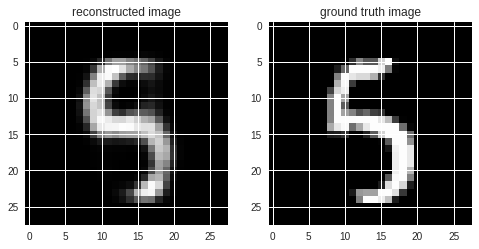

In [53]:
i = 20
plt.subplot(1,2,1)
plt.title('reconstructed image')   
im_recon = np.reshape(reconstruct_mean[i], (28,28))
plt.imshow(im_recon,cmap="gray")


plt.subplot(1,2,2)
plt.title('ground truth image')   
im_recon = np.reshape(x_sample[i], (28,28))
plt.imshow(im_recon, cmap="gray")
plt.show()

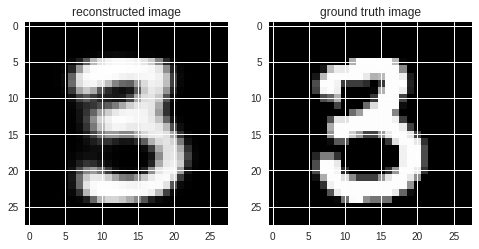

In [27]:
i = 2
plt.subplot(1,2,1)
plt.title('reconstructed image')   
im_recon = np.reshape(reconstruct_mean[i], (28,28))
plt.imshow(im_recon,cmap="gray")


plt.subplot(1,2,2)
plt.title('ground truth image')   
im_recon = np.reshape(x_sample[i], (28,28))
plt.imshow(im_recon,cmap="gray")
plt.show()

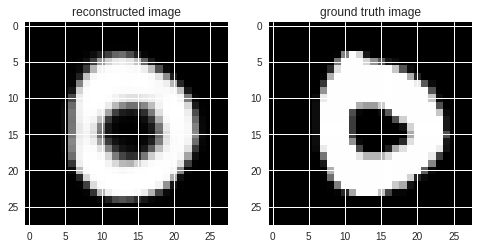

In [105]:
i = 68
plt.subplot(1,2,1)
plt.title('reconstructed image')   
im_recon = np.reshape(reconstruct_mean[i], (28,28))
plt.imshow(im_recon,cmap="gray")


plt.subplot(1,2,2)
plt.title('ground truth image')   
im_recon = np.reshape(x_sample[i], (28,28))
plt.imshow(im_recon,cmap="gray")
plt.show()

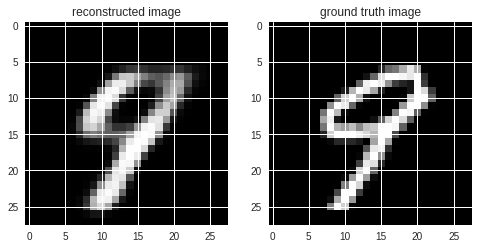

In [29]:
i = 3
plt.subplot(1,2,1)
plt.title('reconstructed image')   
im_recon = np.reshape(reconstruct_mean[i], (28,28))
plt.imshow(im_recon,cmap="gray")


plt.subplot(1,2,2)
plt.title('ground truth image')   
im_recon = np.reshape(x_sample[i], (28,28))
plt.imshow(im_recon,cmap="gray")
plt.show()

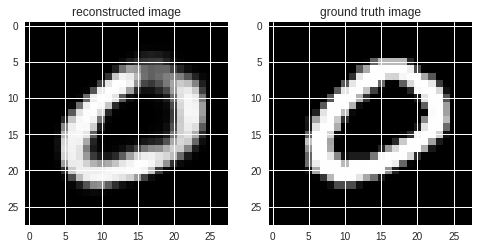

In [78]:
i = 9
plt.subplot(1,2,1)
plt.title('reconstructed image')   
im_recon = np.reshape(reconstruct_mean[i], (28,28))
plt.imshow(im_recon,cmap="gray")


plt.subplot(1,2,2)
plt.title('ground truth image')   
im_recon = np.reshape(x_sample[i], (28,28))
plt.imshow(im_recon,cmap="gray")
plt.show()

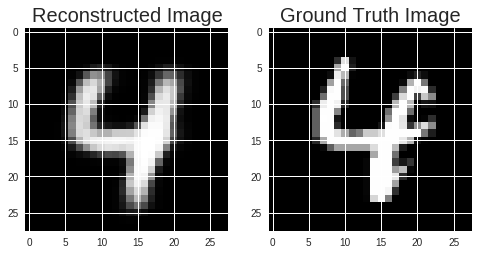

In [109]:
i = 42
plt.subplot(1,2,1)
plt.title('Reconstructed Image', fontsize=20)   
im_recon = np.reshape(reconstruct_mean[i], (28,28))
plt.imshow(im_recon,cmap="gray")


plt.subplot(1,2,2)
plt.title('Ground Truth Image', fontsize=20)   
im_recon = np.reshape(x_sample[i], (28,28))
plt.imshow(im_recon,cmap="gray")
plt.show()

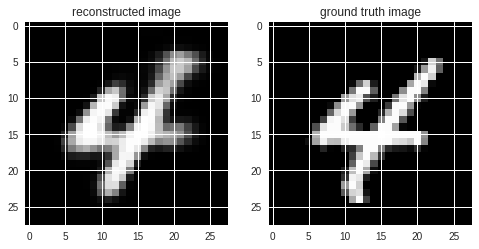

In [85]:
i = 97
plt.subplot(1,2,1)
plt.title('reconstructed image')   
im_recon = np.reshape(reconstruct_mean[i], (28,28))
plt.imshow(im_recon,cmap="gray")


plt.subplot(1,2,2)
plt.title('ground truth image')   
im_recon = np.reshape(x_sample[i], (28,28))
plt.imshow(im_recon,cmap="gray")
plt.show()